### Project XGboost

### Predictive Customer Retention Model using XGBoost & SHAP
Description:
Customer Churn is a rate at which customers stop doing business with an entity. It is one of the most important metrics for subscription businesses. Acquiring a new customer is often 5-25 times more expensive than retaining an existing one.
In this project I developed a Machine Learning solution to predict customer attrition within Telecommunications firm. The goal was not only to predict who will leave but to understand why, providing the business with actionable insights to improve retention strategies.

### Methodology
1. Data processing: Cleaned and transformed a dataset of more than 7000 customers, handling missing values and performing one-hot enconding on categorical variables.
2. Exploratory data analysis EDA: Identified key trends, correlations between high monthly charges and increased churn rates.
3. Modeling: Implemented a XGBoost, chosen for its speed and performance with tabular data.
4. Interpretability: Used a SHapley Additive exPlanations (SHAP), to deconstruct the "Black Box" model and indetify the top drivers of churn.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [55]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Usuario\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


In [56]:
import os

#files inside the carpet
print(os.listdir(path)) 



['WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [57]:
# load the specific data path + the file name 
archivo = path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(archivo)

# Verificar
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
960,2826-DXLQO,Male,1,Yes,No,7,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),29.80,220.45,No
4640,1853-UDXBW,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.00,70,Yes
5124,7267-FRMJW,Female,0,Yes,Yes,25,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.10,486.05,No
6066,5349-IECLD,Male,0,No,No,2,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,94.95,178.1,Yes
4023,1686-STUHN,Male,0,No,No,42,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),19.80,849.9,No


In [58]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 



The TotalCharges column comes as a string, I must use pd.to_numeric and manage the null values.

In [60]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# check null values
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [61]:
# delete 11 rows that do not have data charge 
df.dropna(inplace=True)

Visualization: Use seaborn to check any correlations. 
The clients who pay more monthly are the ones that leave sooner?

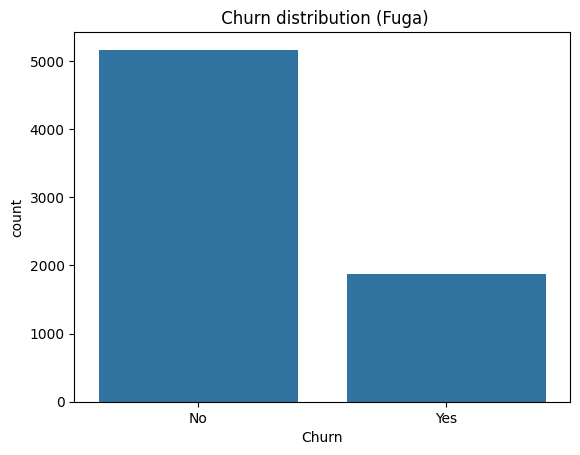

In [62]:
# Check the imbalance (How many left?)
#  need to know if the number of people staying is the same as the number leaving.
sns.countplot(x='Churn', data=df)
plt.title(" Churn distribution (Fuga)")
plt.show()


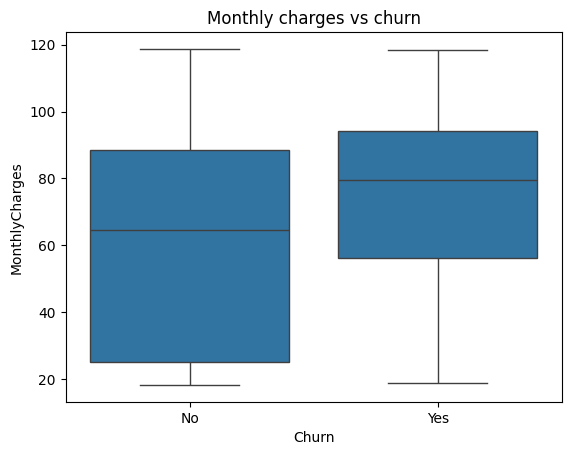

In [63]:
#money vs churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly charges vs churn")
plt.show()

Insight: The higher prices cause churn.

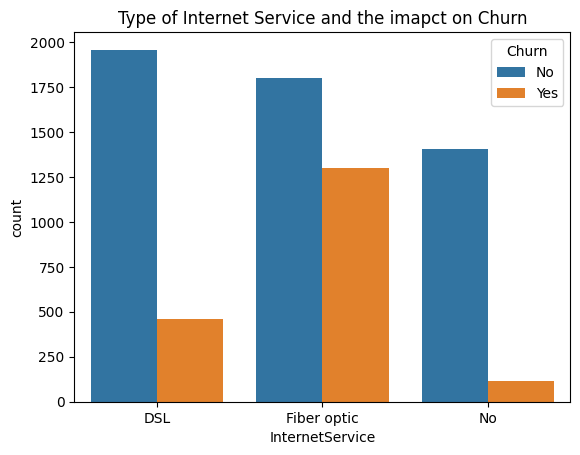

In [64]:
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title("Type of Internet Service and the imapct on Churn")
plt.show()

### Insights
- Fiber Optic users represent a risk: The service might be fast, but maybe it's too expensive or has technical issues (that's why they leave).
- Price Sensitivity: People paying more are leaving more.

In [ ]:
# Remove useless data anad convert text to numbers
# 'customerID' doesn't help predict anything.
df.drop('customerID', axis=1, inplace=True)

#Convert the Target variable ('Churn') manually to 0 and 1
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

#Convert all other categorical columns (gender, internet service, etc.) into numbers
# pd.get_dummies(df): converts all categorical columns to dummy variables
#drop_first=True : drops the first dummy column for each category to avoid multicollinearity (the "dummy variable trap")
df_clean = pd.get_dummies(df, drop_first=True)

#check the new data
print(df_clean.head())

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                            True  ...                            False   
1                           False  ...                            Fa

Time to begin with training

In [ ]:
from sklearn.model_selection import train_test_split

#Separate features (X) and target (y)
X = df_clean.drop('Churn', axis=1) # everything EXCEPT the answer
y = df_clean['Churn']              # The answer (did they leave?)

# ensure everything is numeric (converts True/False to 1.0/0.0)
X = X.astype(float)

# split the data
# random_state=42 ensures we get the same split every time (good for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the sizes
print(f"Training rows: {X_train.shape[0]}")
print(f"Testing rows: {X_test.shape[0]}")

Training rows: 5625
Testing rows: 1407


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

#Initialize the XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Predict yes or no
    n_estimators=100,             # number of decision trees to build
    learning_rate=0.1,            # how fast the model learns (0.1 is standard)
    max_depth=4,                  # how complex each tree is (keep it low to avoid overfitting)
    random_state=42
)

#Train the model
model.fit(X_train, y_train)

# predictions (test)
y_pred = model.predict(X_test)

#check
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f} (That means {accuracy*100:.1f}%)")
print("\nDetailed Report:\n", classification_report(y_test, y_pred))




Model Accuracy: 0.80 (That means 80.2%)

Detailed Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1033
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



The model detects a 80.2% of accuracy, which is solid, however the model only detects 51% of the people who actually leave. It misses the other half.

In [ ]:
# I will change the model to improve the recall
# first, calculate the class weight (Imbalance Ratio)
# formula: Count of Negatives (No Churn) / Count of Positives (Yes Churn)
# This tells the model to put more attention on minorities (who left, churn=1)
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
print(f"Imbalance Ratio: {ratio:.2f}")

# Retrain the model using scale_pos_weight
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    scale_pos_weight=ratio  # parameter to fix the recall
)

# fit the model to the training data
model.fit(X_train, y_train)

# predictions on the test
y_pred_tuned = model.predict(X_test)

# improved report
print("\nImproved Report")
print(classification_report(y_test, y_pred_tuned))

Imbalance Ratio: 2.76

Improved Report (Focused on Recall):
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



#### Why 73% Accuracy > 80% Accuracy?

In Churn Prediction, accuracy can be a misleading metric due to class imbalance (more loyal customers than churners). A model can achieve 80% accuracy simply by predicting that no one will leave, but this provides zero value to the business.

I optimized the model to prioritize Recall (Sensitivity) over overall Accuracy. Here is the breakdown of why this strategic decision maximizes revenue:

The Cost Matrix

- False Negative (The "Missed Opportunity"): The model predicts a customer will stay, but they leave.
Business Cost: Loss of Customer Lifetime Value (CLV).

- False Positive (The "False Alarm"): The model predicts a customer will leave, but they are happy.
Business Cost: Cost of a retention incentive, like a 10% discount email.

Recall (Churn):  before 51% and now	79%	
With 79% of recall the model captures more at risk customers.

We need to know which variables are making the model decide if someone leaves. Is it the Price? The Contract?

<Figure size 1000x600 with 0 Axes>

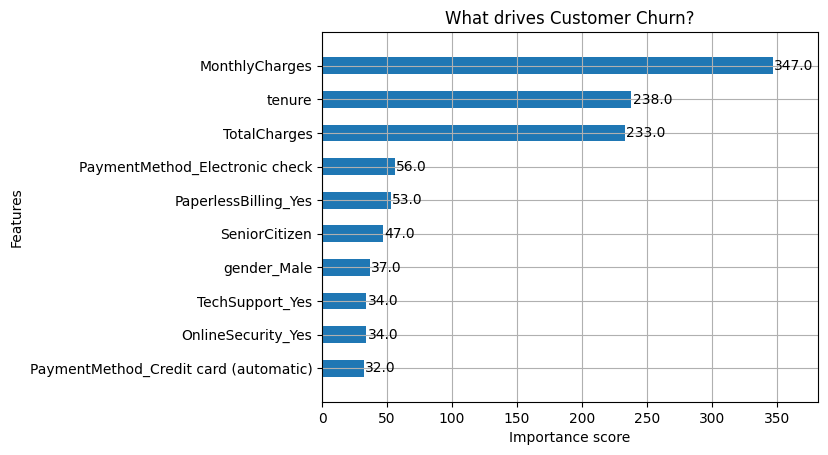

In [ ]:

#top 10 features
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, height=0.5)
plt.title("What drives Customer Churn?")
plt.show()

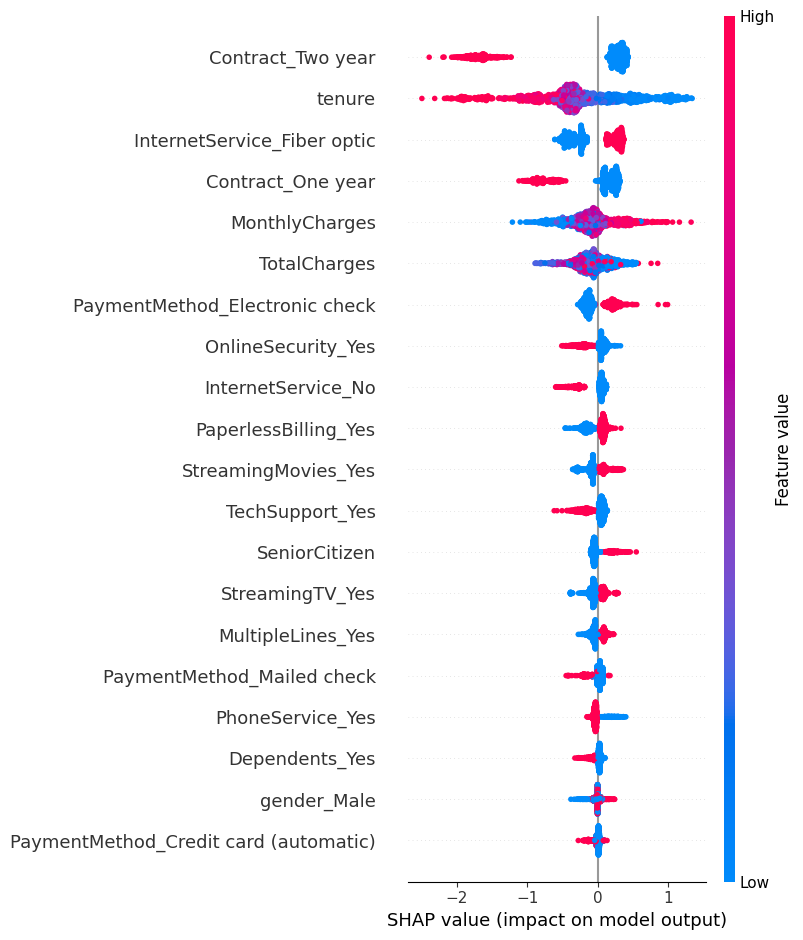

In [70]:
import shap

# 1. Create the explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

#summary plot
shap.summary_plot(shap_values, X_test)


- Tenure: Blue dots (Low tenure/New customers) on the Right side.
Insight: New customers are the most likely to leave. If they survive the first few months (Red dots/High tenure on the left), they become loyal.
- Contract_Two_Year: Red dots (Has a 2-year contract). They are way over on the Left.
Insight: Locking people into long contracts is the #1 way to stop churn.
- InternetService_Fiber_Optic (Third Row): Red dots (Has Fiber). They are pushed to the Right.
Insight: This confirms it. Having Fiber Optic actually increases the chance of a customer leaving. (This is a huge red flag for the company's quality team).

### Based on SHAP/ Feature importance
Through the SHAP analysis, the model revealed that the decision to leave is not random. The top 3 factors of the churn are:
1. Contract type: Customers with monthly contracts have the highest likelihood of churning. They lack the commitment barrier of a 1 or 2 year contract.
2. Internet service (fiber optic): Fiber optic users are churning more than DSL users. It might be due to potential problems with the service quality or that the price point for fiber is too high for the perceived value.
3. Monthly charges: There us a direct positive correlation between higher bills and churn. Price sensitivity is a major factor.

## Business Recommendations (Actionable Insights):

Based on these data-driven findings, I would recommend the following strategies to the stakeholders:

- Push for Contracts: Offer a small discount to monthly users if they switch to a 1 year contract to lock them in.
- Investigate Fiber Optic: The technical team needs to review the Fiber Optic infrastructure for stability issues, as high churn in a premium service is a red flag.
- Targeted Discounts: Use the model to flag high-risk customers (high probability) and offer them a proactive retention incentive before they cancel.